# Plotting feature importances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.metrics import accuracy_score

from rfpimp import *

## Rent data set, classify interest in ad

In [2]:
df_all = pd.read_csv("data/rent-cls.csv") 

num_features = ['bathrooms','bedrooms','latitude','longitude','price']
target = 'interest_level'

df = df_all[num_features + [target]]
df_train, df_test = train_test_split(df, test_size=0.15)

X_train, y_train = df_train.drop('interest_level',axis=1), df_train['interest_level']
X_test, y_test = df_test.drop('interest_level',axis=1), df_test['interest_level']

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
#                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1.0, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

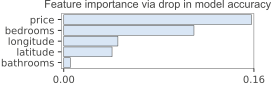

In [3]:
I = importances(rf, X_test, y_test)
plot_importances(I)

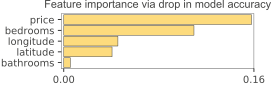

In [4]:
plot_importances(I, color='#FDDB7D')

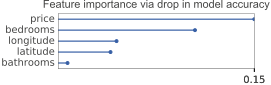

In [5]:
stemplot_importances(I, vscale=.7)

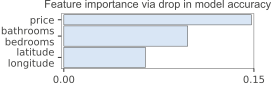

In [6]:
I = importances(rf, X_test, y_test, features=['price',['latitude','longitude']])
plot_importances(I)

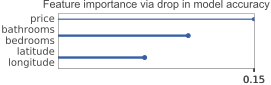

In [7]:
stemplot_importances(I, vscale=.7)

## Breast cancer data set, classify malignant/benign

In [8]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target
# show first 5 columns only
# df = pd.DataFrame(X[:, 0:10], columns=cancer.feature_names[0:10])
df = pd.DataFrame(X, columns=cancer.feature_names)

#df['diagnosis'] = cancer.target
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.15)

cl = RandomForestClassifier(n_estimators=500, oob_score=True)
cl.fit(X_train, y_train)
print(cl.oob_score_)
print( cl.score(X_test, y_test) )

0.9668737060041408
0.9302325581395349


### Default importances via gini/variance drop

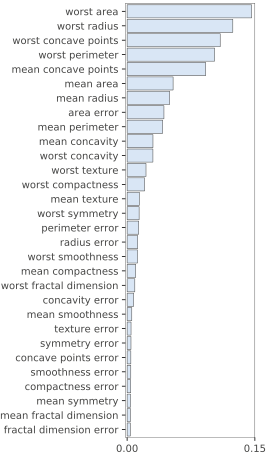

In [9]:
I = pd.DataFrame()

I['Feature'] = X_train.columns
I['Importance'] = cl.feature_importances_
I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')
viz = plot_importances(I,
#                 width=6,
#                 color='#FDDB7D',
#                 bgcolor='#F1F8FE',
#                 title="Feature importance via average gini/variance drop (sklearn)"
                       title=None
                      )
viz.save('../article/images/cancer_dflt_imp.svg')
viz

### Permutation importance

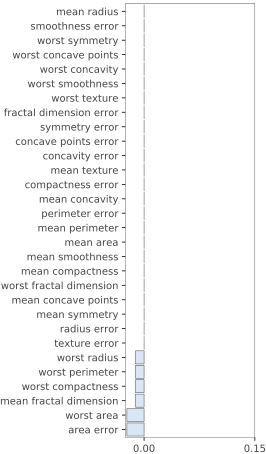

In [10]:
I = importances(cl, X_test, y_test)
viz = plot_importances(I, title=None)
viz.save('../article/images/cancer_imp.svg')
viz

### Drop column importance

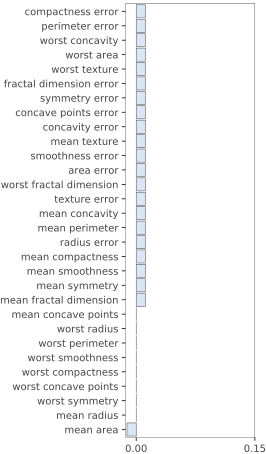

In [11]:
I = dropcol_importances(cl, X_train, y_train, X_test, y_test)
viz = plot_importances(I, title=None)
viz.save('../article/images/cancer_dropcol_imp.svg')
viz

### Drop column importance using OOB score

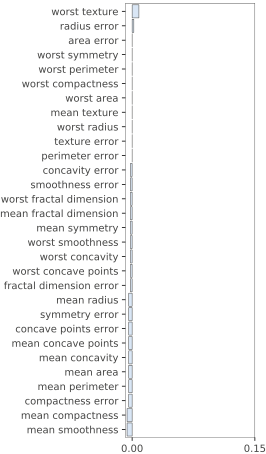

In [12]:
I = oob_dropcol_importances(cl, X_train, y_train)
viz = plot_importances(I, title=None)
viz

This obviously means that the features are highly collinear. Verified via:

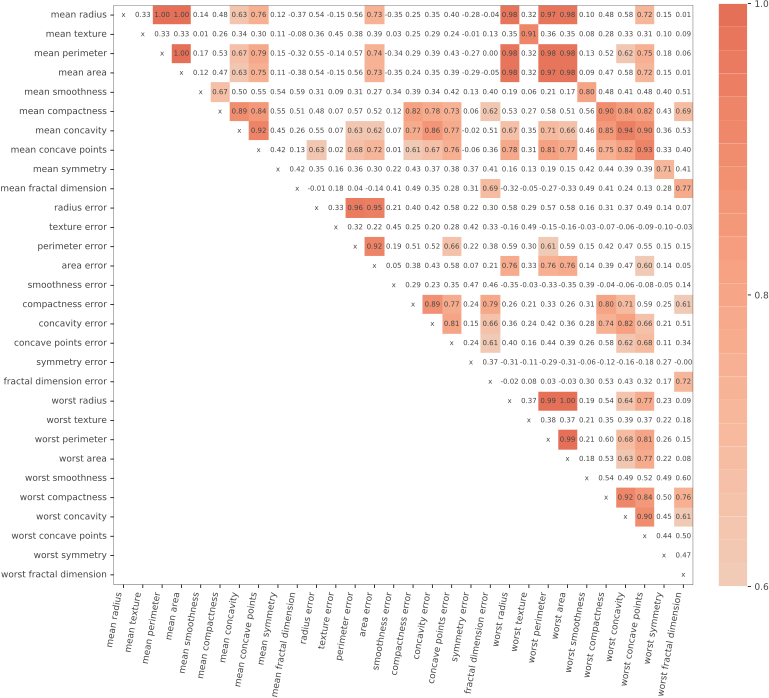

In [13]:
viz = plot_corr_heatmap(X_train, figsize=(11,11), label_fontsize=9, value_fontsize=7)
viz.save('../article/images/cancer_corr.svg')
viz

Wow. And look at the predictability (R^2 or accuracy depending on column type) of the variables using other variables:

In [14]:
pd.set_option('precision', 3)
D = feature_dependence_matrix(X_train, sort_by_dependence=True)

In [15]:
D.columns

Index(['Dependence', 'mean radius', 'mean texture', 'mean perimeter',
       'mean area', 'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [16]:
D['Dependence'].sort_values(ascending=False)

mean radius                0.996
worst radius               0.993
mean perimeter             0.992
mean area                  0.985
worst perimeter            0.984
worst area                  0.98
mean concave points        0.945
mean concavity             0.937
worst concave points       0.929
mean compactness            0.92
worst compactness          0.899
worst concavity            0.898
radius error               0.886
perimeter error            0.886
worst texture              0.885
mean texture               0.859
worst fractal dimension    0.856
compactness error          0.853
mean fractal dimension     0.823
worst smoothness            0.79
concave points error       0.773
mean smoothness            0.765
area error                 0.763
worst symmetry             0.725
fractal dimension error    0.701
mean symmetry              0.656
concavity error            0.618
texture error              0.547
symmetry error             0.545
smoothness error           0.414
Name: Depe

In [17]:
D = feature_dependence_matrix(X_train)

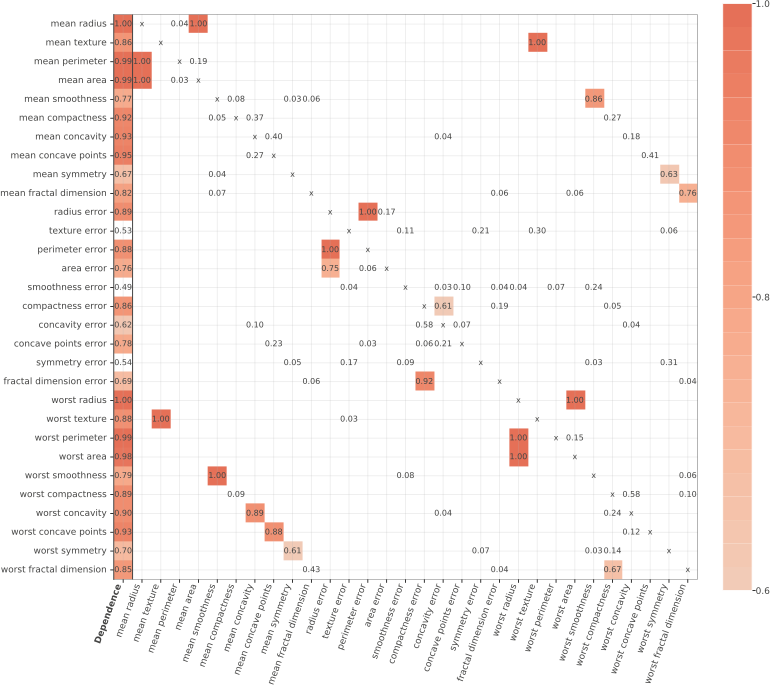

In [18]:
viz = plot_dependence_heatmap(D, figsize=(11,10))
viz.save('../article/images/cancer_dep.svg')
viz

Let's drop some columns And check out the accuracy

In [19]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target
# show first 5 columns only
# df = pd.DataFrame(X[:, 0:10], columns=cancer.feature_names[0:10])
df = pd.DataFrame(X, columns=cancer.feature_names)
df = df.drop('mean perimeter', axis=1)
df = df.drop('mean area', axis=1)
df = df.drop('perimeter error', axis=1)
df = df.drop('area error', axis=1)
df = df.drop('mean texture', axis=1)
df = df.drop('concavity error', axis=1)
df = df.drop('fractal dimension error', axis=1)
df = df.drop('worst perimeter', axis=1)
df = df.drop('worst area', axis=1)

#df['diagnosis'] = cancer.target
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.15)

cl = RandomForestClassifier(n_estimators=100, oob_score=True)
cl.fit(X_train, y_train)
print(cl.oob_score_)
print( cl.score(X_test, y_test) )

0.9565217391304348
0.9534883720930233


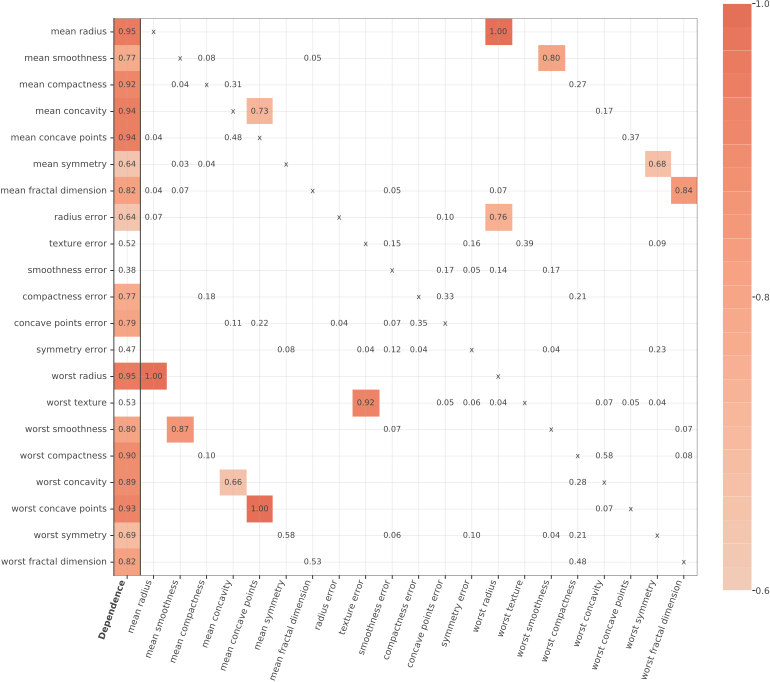

In [20]:
D = feature_dependence_matrix(X_train)
viz = plot_dependence_heatmap(D, figsize=(11,10))
viz.save('../article/images/cancer_dep_less4.svg')
viz